> 은행과 같은 금융기관의 리테일 금융소비자(개인 고객)에 대하여 가계신용대출(Home Credit Loan)을 할 경우 **고객이 대출금을 상환할지 Target 변수 분류 및 대출금액 예측** 프로젝트

### 신용대출상환 여부 TARGET 분류를 위한 베이스라인 모델 구축

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import missingno as msno
from typing import *
  # [데이터프레임 핸들링, 선형대수, 결측값 처리 목적 라이브러리 모듈]

from google.colab import drive
drive.mount("/content/drive")
  # [코랩에 구글 드라이브 마운트]

from sklearn.preprocessing import *
  # [연속형 변수 스케일링 및 범주형 변수 인코딩 목적 모든 라이브러리 모듈]
from sklearn.model_selection import train_test_split
  # [훈련용 및 검증용 데이터 셋 분할 목적 라이브러리 모듈]
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
  # [K-폴드 교차검증(랜덤 또는 타겟하는 클래스 변수 비율 층화) 및 그리드 서치 목적 라이브러리 모듈]

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import export_graphviz
  # [데이터 시각화 모듈]

from sklearn.tree import DecisionTreeClassifier
import graphviz
from sklearn.tree import export_graphviz
from sklearn.tree import plot_tree
from sklearn.tree import export_text
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from lightgbm import plot_importance

from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import CategoricalNB
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from mlxtend.plotting import plot_decision_regions
  # [분류 모델 모듈]

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score, classification_report
  # [성능 평가 지표 모듈]

from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTENC
  # [클래스 불균형 모듈]

from sklearn.decomposition import PCA
  # [클래스 불균형 확인 시각화 모듈]

from sklearn.metrics import fbeta_score, make_scorer
  # [f-beta score 모듈]

Mounted at /content/drive


#### 1) 의사결정 트리 분류 모델
- 디폴트 상태에서 성능 평가를 통한 클래스 불균형, 과대 적합 확인
- split_ratio에 따른 성능 평가 지표 확인 
- 지니 불순도, 엔트로피 불순도에 따른 변화 확인


##### (0) 클래스 불균형 조정 
* ADASYN, SMOTE :  K-최근접 이웃 알고리즘 기반의 합성과잉표본추출 기법
* 가중치 설정 : 아래 정의한 함수 내에서 가중치 설정과 하이퍼파라미터 조정을 동시에 진행함.
* https://jair.org/index.php/jair/article/view/10302/24590
* https://www.youtube.com/watch?v=LYg4R7Tv1v8
* SMOTE-NC : 클래스 0과 1을 포함하는 더미변수와 같이 범주형 데이터를 인코딩하는 경우 샘플 결과는 0.8 또는 0.34 등이 될 수 있다. 따라서 SMOTE-NC를 사용하여 범주형 데이터 오버샘플링이 타당한지 확인한다.

  > ClassWeightMaxDepth( ) : 최적의 가중치 탐색
  >
  > DecisionTreeMaxDepth(  ),: 최적의 max_depth 탐색
  > 
  > DecisionTreeCostComplexity(  ) : 최적의 ccp_alpha 탐색
  > 
  > DecisionTreeOverFittingTest ( ) : 하이퍼파라미터 설정 후 모델의 과적합 판정
  > 
  > DecisionTreeCustom( ) : 최종 모델 성능 평가 및 feature importance 추출 

```
# New Credit Bureau _ Impute NA with MICE _ Feature Selection with PCA, Filtering _ Outlier Detection with Isolation Forest

NCB_MICE_FS_OD = pd.read_csv("/content/drive/MyDrive/NCB_MICE_FS.csv", index_col = False)
NCB_MICE_FS_OD.shape
  
# 연속형 변수 중 실수를 소수점 첫째 자리에서 정수로 반올림

NCB_MICE_FS_OD = round(NCB_MICE_FS_OD, 0)
# 실수(float)를 정수(integer)로 타입 변환
columns_float_list = NCB_MICE_FS_OD.select_dtypes(include = ["float"]).columns.tolist()
NCB_MICE_FS_OD.loc[:, columns_float_list] = NCB_MICE_FS_OD.loc[:, columns_float_list].astype("int")

# 더미변수를 8byte의 부호 없는 정수 타입, "uint8"으로 변환

NCB_MICE_FS_OD.iloc[:, 6:124] = NCB_MICE_FS_OD.iloc[:, 6:124].astype("uint8")
NCB_MICE_FS_OD["duplicate"] = NCB_MICE_FS_OD["duplicate"].astype("uint8")

X = NCB_MICE_FS_OD.drop(["TARGET", "SK_ID_CURR", "SK_ID_PREV"], axis = 1)
y = NCB_MICE_FS_OD["TARGET"]
```

```
# 표준화 할지 결정하기 -> 수행하지 않음

X = NCB_MICE_FS_OD.drop(["TARGET", "SK_ID_CURR", "SK_ID_PREV"], axis = 1)
scaler = StandardScaler()
  # [표준화가 모델 성능에 미치는 영향은 없음]

X_num_list = X.select_dtypes(include = ["integer", "float"]).columns.tolist()
X.loc[:, X_num_list] = scaler.fit_transform(X.loc[:, X_num_list])
y = NCB_MICE_FS_OD["TARGET"]
```

```
# 범주형 더미변수의 컬럼 번호(위치) 반환

columns_dummy_list = X.select_dtypes(include = ["uint8"]).columns.tolist()
columns_category_list: List = []

for columns in columns_dummy_list:
  columns_category_list.append(X.columns.get_loc(columns))
```

```
# 합성표본추출기법 SMOTE_Nominal Continuous 활용] 5:5 클래스 균형 (16분 소요)

smoteNC = SMOTENC(random_state = 2022, k_neighbors = 5, sampling_strategy = "minority",
                  categorical_features = columns_category_list)
X_smote, y_smote = smoteNC.fit_resample(X, y)

X_smote.to_csv("/content/drive/MyDrive/Xsmote.csv", index = False)
y_smote.to_csv("/content/drive/MyDrive/ysmote.csv", index = False)
```

In [2]:
X_smote = pd.read_csv("/content/drive/MyDrive/Xsmote.csv", index_col = False)
y_smote = pd.read_csv("/content/drive/MyDrive/ysmote.csv", index_col = False)

In [6]:
X_smote.iloc[:, 6:123] = X_smote.iloc[:, 6:123].astype("uint8")
X_smote.iloc[:, 125] = X_smote.iloc[:, 125].astype("uint8")
y_smote = y_smote.astype("category")

In [7]:
X_smote.info()
y_smote.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 575566 entries, 0 to 575565
Columns: 126 entries, DAYS_EMPLOYED to duplicate
dtypes: int64(8), uint8(118)
memory usage: 99.9 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 575566 entries, 0 to 575565
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype   
---  ------  --------------   -----   
 0   TARGET  575566 non-null  category
dtypes: category(1)
memory usage: 562.3 KB


```
# sampling_strategy로 불균형 비율 설정하기

smote_2 = SMOTE(random_state = 2022, k_neighbors = 5, sampling_strategy = {1:25736*6})
X_smote2, y_smote2 = smote_2.fit_resample(X, y)

print(X_smote2.shape, y_smote2.shape)
Counter(y_smote2)
  # [합성표본추출기법 SMOTE 활용] {1:4}, {1:3}, {1:2} 클래스 균형
  # [sampling_strategy = {1:77208}, Counter({1: 77208, 0: 287783})]
  # [sampling_strategy = {1:102944}, Counter({1: 102944, 0: 287783})]
  # [sampling_strategy = {1:154416}, Counter({1: 154416, 0: 287783})]
```

```
# SMOTE로 인해 과잉표본추출된 데이터를 제거하기 위한 과정
# outer merge를 이용하여 제거하려고 했으나 세션이 다운돼서 진행할 수 없음

df = pd.merge(X, X_smote, how='outer', indicator = True)
df2 = pd.merge(y, y_smote, how='outer', indicator = True)
df.query('_merge == "right_only"').drop(columns=['_merge'])
df2.query('_merge == "right_only"').drop(columns=['_merge'])
```

##### X_smote 데이터에 파생변수 생성 : "세대" 변수 만들기
* DAYS_BIRTH / 365

In [8]:
X_smote["DAYS_BIRTH"].isnull().sum()

0

In [9]:
# 세대 변수 만들기

X_smote["GENERATION"] = round(X_smote["DAYS_BIRTH"] / 365, 0)

def DAYS_BIRTH_category(age):
  age = (age // 10) * 10
    # [24 나누기 10의 몫인 2에 10을 곱하여 20대로 정의]
  return age

X_smote["GENERATION"] = X_smote["GENERATION"].apply(DAYS_BIRTH_category)
  # [DAYS_BIRTH를 GENERATION으로 파생한 함수를 정의하여 NICE_MICE_FS_OD 데이터 프레임 내 변수(시리즈)에 적용]
X_smote["GENERATION"] = X_smote["GENERATION"].astype("category")
  # [연속형에서 범주형으로 타입 변환]
X_smote = pd.get_dummies(X_smote, columns = ["GENERATION"])
  # [더미 변수로 변환]
X_smote.head()

for i in [20.0, 30.0, 40.0, 50.0, 60.0]:
  print(Counter(X_smote["GENERATION_{}".format(i)]))

<ipython-input-9-8202be7faa46>:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X_smote["GENERATION"] = round(X_smote["DAYS_BIRTH"] / 365, 0)


Counter({0: 483878, 1: 91688})
Counter({0: 385494, 1: 190072})
Counter({0: 431365, 1: 144201})
Counter({0: 482089, 1: 93477})
Counter({0: 519438, 1: 56128})


In [10]:
91688 + 190072 + 144201 + 93477 + 56128
  # ["GENERATION_{}".format(i*10)이 1인 데이터 수와 전체 행의 수의 일치 여부 확인]

575566

In [12]:
X_smote.drop(["DAYS_BIRTH"], axis = 1, inplace = True)

```
# 세대(연령대) 변수 생성 시 Trial & Error

for index in range(len(NCB_MICE_FS_OD.index)) :
  if NCB_MICE_FS_OD.loc[index, "GENERATION"] < 20:
    NCB_MICE_FS_OD.loc[index, "GENERATION"] = 10
  elif NCB_MICE_FS_OD.loc[index, "GENERATION"] < 30:
    NCB_MICE_FS_OD.loc[index, "GENERATION"] = 20
  elif NCB_MICE_FS_OD.loc[index, "GENERATION"] < 40:
    NCB_MICE_FS_OD.loc[index, "GENERATION"] = 30
  elif NCB_MICE_FS_OD.loc[index, "GENERATION"] < 50:
    NCB_MICE_FS_OD.loc[index, "GENERATION"] = 40
  elif NCB_MICE_FS_OD.loc[index, "GENERATION"] < 60:
    NCB_MICE_FS_OD.loc[index, "GENERATION"] = 50
  else:
    NCB_MICE_FS_OD.loc[index, "GENERATION"] = 60

  # [세대(나이대) 범주형 변수 생성]
```

##### (1) 클래스 불균형 해소를 위한 클래스 가중치 설정

```
# class_weight = {0:1, 1:3} 일 때의 최적 max_depth

def ClassWeightMaxDepth(split_ratio: float):
  np.random.seed(2023)
  X_train, X_test, y_train, y_test = train_test_split(X,
                                                      y,
                                                      stratify = y,
                                                      random_state = 2022,
                                                      test_size = split_ratio)
  weights = {0:1, 1:3}

  grid_param = {"max_depth" : list(range(17, 24, 1))}

  DT_2 = DecisionTreeClassifier(random_state = 2022, criterion = "gini", class_weight = weights)

  f_beta = make_scorer(fbeta_score, beta=0.75)
  grid_search = GridSearchCV(DT_2, grid_param, cv=5, scoring = f_beta)
  grid_search.fit(X_train, y_train)

  print(f"split_ratio: {split_ratio}")
  print(f"max_depth 최적 파라미터: {grid_search.best_params_}")
  print(f"최적 max_depth일 때의 F-beta값: {grid_search.best_score_}")

    # ClassWeightMaxDepth(split_ratio = 0.5)
    # split_ratio: 0.5
    # max_depth 최적 파라미터: {'max_depth': 23}
    # 최적 max_depth일 때의 F-beta값: 0.24049667466228467
```

In [22]:
# dt_eval()
# 혼동행렬, 정확도, 민감도, 재현율, f1스코어를 한번에 출력하는 함수

def dt_eval(y_test, y_pred) :
  confusion = confusion_matrix(y_test, y_pred, labels = [1,0])
      # [1(양성)이 먼저 오는 혼동행렬 그리기]
  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  print("혼동 행렬")
  print(confusion)
  
  print(f"정확도: {accuracy}")
  print(f"정밀도: {precision}")
  print(f"재현율: {recall}")
  print(f"F1: {f1}")
  print(f"F-0.75: {((1+0.75**2) * precision * recall) / ((0.75**2)*precision + recall)}")

##### (2) 의사결정트리의 하이퍼파라미터를 튜닝하는 과정에서 발견한 몇가지 규칙성

> DecisionTreeMaxDepth()
* 다수 : 소수 클래스 가중치를 **1 : 12(1/소수 클래스 확률값)**로 주어 **5:5 균형인 상황**보다 **1 : 3**으로 주어 **4:1의 클래스 불균형이 완화된 상황**에서 performance measure인 F-0.75 점수가 유리함을 확인함
* Train 데이터를 train(80%) : validation(20%)으로 분할하여 5겹 교차검증을 수행한 결과보다 Train(train + validataion, 80%) : Test(20%)로 분할하여 수행한 결과가 더 유리함을 확인함
* 의사결정 트리 분류기의 GridSearchCV(격자탐색 교차검증)에서 최적화된 하이퍼파라미터 값(트리의 최대 깊이)로 그리드 내 가장 큰 수를 반환함
* train : test의 분할 비율은 5:5, train에서 다시 분할하여 k겹 교차검증(cross validation)할 train : validation의 비율은 8:2로 설정(k = 5)

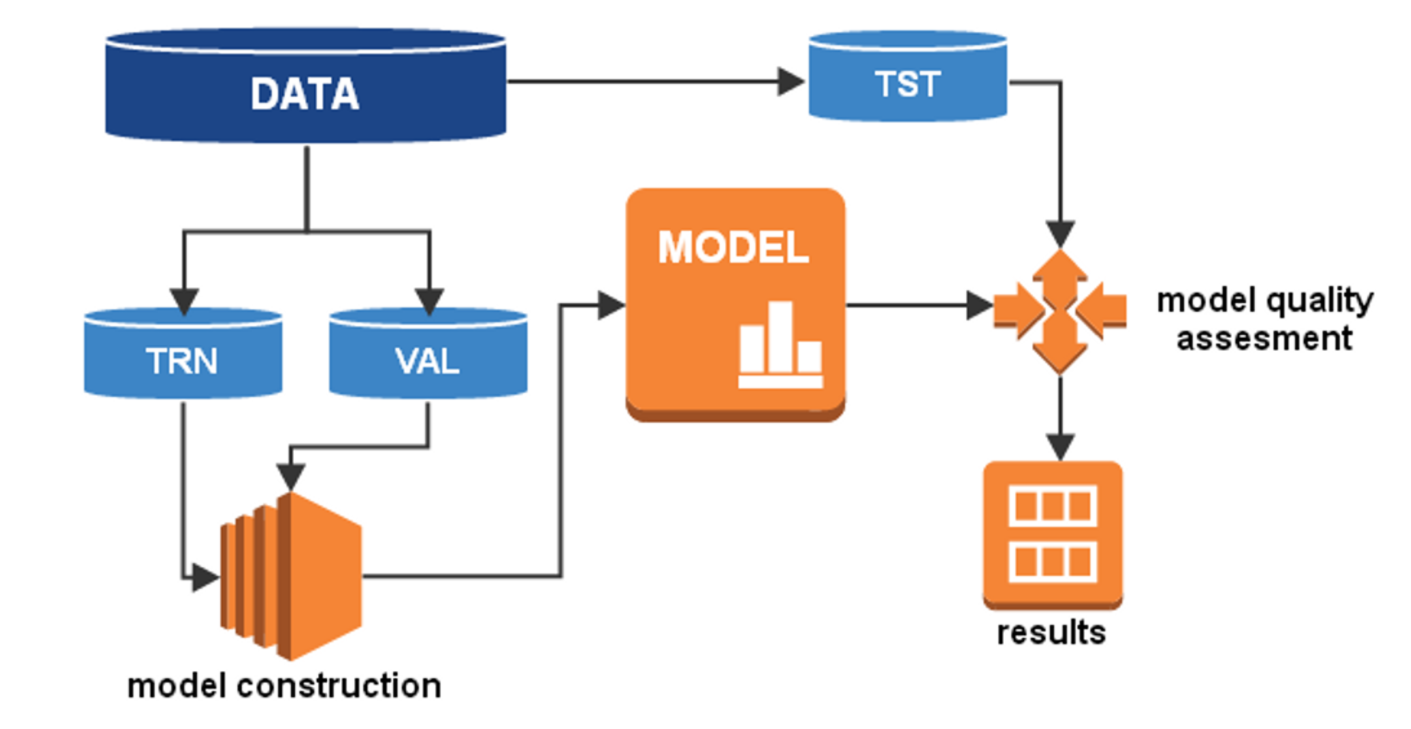

In [55]:
# DecisionTreeMaxDepth()
# max_depth 그리드 서치, class_weight(가중치 신용위험에 대한 가중치 1/p, (p=연체확률값)) -> smote(synthetic minority over sampling)

def DecisionTreeMaxDepth(X: pd.DataFrame, 
                         y: pd.Series):

  np.random.seed(2022)
  X_train, X_test, y_train, y_test = train_test_split(X,
                                                      y,
                                                      stratify = y,
                                                      test_size = 0.5,
                                                      random_state = 2022)
  
  # default_wt = round(1/np.mean(y_train==1), 0)
  # target_wt = [default_wt if target == 1 else 1 for target in y_train]
    # [클래스별 가중치 설정] 신용위험에 대한 가중치 1/p, (p=연체확률값)
    # [fit() 함수의 파라미터인 [sample_weight]의 값으로 들어가야 함]
  
  DT = DecisionTreeClassifier(random_state = 2022, criterion = "gini")

  grid_param = {"max_depth" : list(range(8, 24, 1))}
    # dictionary type의 grid_param에 max_depth(트리의 최대 깊이)에 대한 그리드를 17부터 23까지 list로 value를 저장
  f_beta = make_scorer(fbeta_score, beta = 0.75)
    # [beta = 0.75 : 정밀도에 대한 높은 가중치 8/10, 9/13 의 중간값]
    # [beta = 1.35 : 재현율에 대한 높은 가중치 10/8, 13/9의 중간값]
  k_fold = StratifiedKFold(5, shuffle = True, random_state = 2022)
    # [층화 k = 5 폴드 교차검증]

  grid_search = GridSearchCV(DT, grid_param, cv = k_fold, scoring = f_beta)
  grid_search.fit(X_train, y_train)
    # [cv = 5] 교차검증할 데이터 셋의 분할 비율을 8:2로 설정
    # [grid_search의 parameter] sample_weight = target_wt를 제외

  print(f"max_depth 최적 파라미터: {grid_search.best_params_}")
  print(f"최적 max_depth일 때의 F-beta값: {grid_search.best_score_}")
  # print(grid_search.cv_results_)

In [52]:
# F-Beta의 B = 0.75일 때

DecisionTreeMaxDepth(X = X_smote.drop(["CODE_GENDER_M", "CODE_GENDER_F"], axis = 1),
                     y = y_smote)
  # [그리드를 8부터 23까지 설정하고 탐색하였을 때, 최적값은 23]
  # [최적 max_depth일 때의 F-0.75 점수: 78.86%] train으로 학습한 모델을 validation으로 평가

max_depth 최적 파라미터: {'max_depth': 23}
최적 max_depth일 때의 F-beta값: 0.7886111627625516


In [54]:
# F-Beta의 B = 1.35일 때

DecisionTreeMaxDepth(X = X_smote.drop(["CODE_GENDER_M", "CODE_GENDER_F"], axis = 1),
                     y = y_smote)
  # [그리드를 8부터 23까지 설정하고 탐색하였을 때, 최적값은 23]
  # [최적 max_depth일 때의 F-1.35 점수: 83.08%] train으로 학습한 모델을 validation으로 평가

max_depth 최적 파라미터: {'max_depth': 23}
최적 max_depth일 때의 F-beta값: 0.8308269510748121


In [25]:
# DecisionTreeOverfittingTest()
# train data로 훈련시킨 모델을 test data와 train data로 각각 예측한 성능지표의 균형 비교하여 과적합 판단

def DecisionTreeOverfittingTest(X: pd.DataFrame, 
                                y: pd.Series,
                                depths: float,
                                impurity: object):
  
  np.random.seed(2022)
  X_train, X_test, y_train, y_test = train_test_split(X,
                                                      y,
                                                      stratify = y,
                                                      test_size = 0.5,
                                                      random_state = 2022)
  dt = DecisionTreeClassifier(max_depth = depths, 
                              random_state = 2022, 
                              criterion = impurity)
  dt.fit(X_train, y_train)

  print(dt_eval(y_test, dt.predict(X_test)))
  print(dt_eval(y_train, dt.predict(X_train)))

In [29]:
# 의사결정트리 노드 분리규칙(불순도) : 지니 지수

DecisionTreeOverfittingTest(X = X_smote.drop(["CODE_GENDER_M", "CODE_GENDER_F"], axis = 1),
                            y = y_smote, depths = 23, impurity = "gini")
  # [제1종오류가 제2종오류보다 발생률이 높은 상황(= 재현률 < 정밀도)]
  # [test data에서의 정밀도가 더 높은 지니 지수를 불순도로 한 의사결정트리를 최종 모델로 선택]

DecisionTreeOverfittingTest(X = X_smote.drop(["CODE_GENDER_M", "CODE_GENDER_F"], axis = 1),
                            y = y_smote, depths = 20, impurity = "gini")
  # [max_depth = 20일 때에 비해 23일 경우 test data에서 정밀도와 재현율의 균형이 확보됨을 확인]

혼동 행렬
[[128431  15461]
 [ 44730  99161]]
정확도: 0.7908458804029425
정밀도: 0.7416854834518165
재현율: 0.8925513579629166
F1: 0.8101547690764636
F-0.75: 0.7897412045049148
None
혼동 행렬
[[137606   6285]
 [ 32754 111138]]
정확도: 0.8643457049235014
정밀도: 0.807736557877436
재현율: 0.956321104169128
F1: 0.8757712783730203
F-0.75: 0.8555929087373366
None
혼동 행렬
[[127524  16368]
 [ 48910  94981]]
정확도: 0.7731693671968115
정밀도: 0.7227858576011427
재현율: 0.8862480193478443
F1: 0.7962138571330458
F-0.75: 0.7741917623529252
None
혼동 행렬
[[134828   9063]
 [ 39655 104237]]
정확도: 0.8307127245181265
정밀도: 0.7727285752766745
재현율: 0.9370148237207331
F1: 0.8469787105730996
F-0.75: 0.8247880282288088
None


In [56]:
# 의사결정트리 노드 분리규칙(불순도) : 엔트로피

DecisionTreeOverfittingTest(X = X_smote.drop(["CODE_GENDER_M", "CODE_GENDER_F"], axis = 1),
                            y = y_smote, depths = 23, impurity = "entropy")

혼동 행렬
[[127945  15947]
 [ 45905  97986]]
정확도: 0.7850741704687212
정밀도: 0.7359505320678746
재현율: 0.8891738248130542
F1: 0.8053389227738228
F-0.75: 0.784625185324734
None
혼동 행렬
[[136024   7867]
 [ 35782 108110]]
정확도: 0.8483266905967344
정밀도: 0.7917302073268687
재현율: 0.9453266708828211
F1: 0.8617376788502901
F-0.75: 0.8409177739888202
None


> DeicisionTreeCostComplexity()

In [31]:
# DeicisionTreeCostComplexity() 
# 의사결정 분류나무의 xerror + alpha*xstd를 최소화하는 ccp_alpha를 찾는 함수
# 출력값은 비용 복잡도(가중계수 alpha)가 증가할 때 트리의 리트노드 불순도의 변화 그래프 

def DecisionTreeCostComplexity(X: pd.DataFrame, 
                               y: pd.Series,
                               # lowclass_weight: float,
                               depths: float):
  
  np.random.seed(2023)
  X_train, X_test, y_train, y_test = train_test_split(X,
                                                      y,
                                                      stratify = y,
                                                      test_size = 0.5,
                                                      random_state = 2022)
    # [훈련용 및 검증용 데이터 셋 분할비율 split_ratio로 입력값 설정]
  # weights = {0:1, 1:lowclass_weight}
    # [클래스별 가중치 설정] 다수클래스 0 = 1, 소수클래스 1 = lowclass_weight로 입력값 설정

  DecisionTree = DecisionTreeClassifier(random_state = 2023,
                                        # class_weight = weights
                                        max_depth = depths)
    # [정지규칙, 가지치기, 분리기준 모두 디폴트 설정]
    # [class_weight 제외] 소수 클래스 TARGET 1 가중치 조정 파라미터 제거
    
  path = DecisionTree.cost_complexity_pruning_path(X_train, y_train)
  ccp_alphas, impurities = path.ccp_alphas, path.impurities
    # [가지치기 과정에서 유효한 알파(가중계수)와 총 리프 노드의 불순도 반환]

  fig, ax = plt.subplots()
  ax.plot(ccp_alphas[:-1], 
          impurities[:-1],
          marker = "o",
          drawstyle = "steps-post")
  ax.set_xlabel("Effective alpha")
  ax.set_ylabel("Total Impurity of leaf nodes")
  ax.set_title("Total Impurity vs effective alpha for training set")  

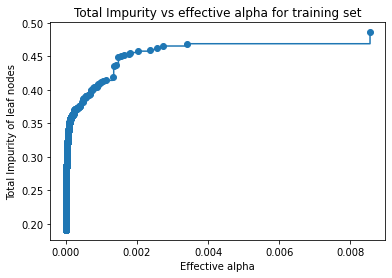

In [32]:
DecisionTreeCostComplexity(X = X_smote.drop(["CODE_GENDER_M", "CODE_GENDER_F"], axis = 1),
                           y = y_smote, depths = 23)
    # [ccp_alpha = 0] ccp_alpha 는 정확도를 높이는 전략이므로 정밀도, 재현율, f1 score 등의 지표는 되려 낮아질 수 있음

##### (3) 최종 모델 (split_ratio = 0.5, max_detpth = 16, ccp_alpha = 0,  criterion = "gini")

> DecisionTreeCustom()

In [33]:
# DecisionTreeCustom() : 의사결정 트리 분류기 적합
# 의사결정 분류나무의 train:test 분할비율, 비용복잡도/가중계수, 소수 클래스 가중치를 입력하여 
# 모형을 적합하고 performance measure(금융회사의 기대손실)을 예측하는 함수
# 출력값은 혼동행렬, 정확도-정밀도-재현율, performance_measure, TARGET = 1이 될 분류 확률의 분포를 나타내는 기술통계량 추출

def DecisionTreeCustom(X: pd.DataFrame, y: pd.Series, split_ratio: float, alpha: float, depth: int, impurity: object):
  np.random.seed(2023)
  X_train, X_test, y_train, y_test = train_test_split(X,
                                                      y,
                                                      stratify = y,
                                                      random_state = 2022,
                                                      test_size = split_ratio)
    # [훈련용 및 검증용 데이터 셋 분할비율 split_ratio로 입력값 설정]

  decisionTreePruned = DecisionTreeClassifier(random_state = 2023, 
                                              max_depth = depth,
                                              ccp_alpha = alpha,
                                              criterion = impurity)

  decisionTreePruned.fit(X_train, y_train)
  y_pred = decisionTreePruned.predict(X_test)
  y_pred = np.array(y_pred)
  y_test = np.array(y_test)
  
  TP = 0
  FN = 0
  FP = 0
  TN = 0

  for i in range(len(y_pred)):
    if y_test[i] == y_pred[i] == 1:
      TP += 1
    if y_test[i] == 1 and y_pred[i] == 0:
      FN += 1
    if y_test[i] == 0 and y_pred[i] == 1:
      FP += 1
    if y_test[i] == 0 and y_pred[i] == 0:
      TN += 1

  confusionMatrix = np.array([[TP, FN], [FP, TN]]).reshape(2, 2)
  print(confusionMatrix)
  Precision = TP / (TP + FP)
  Recall = TP / (TP + FN)
  print("정확도 :", (TP + TN) / (TP + FN + FP + TN))
  print("정밀도 :", Precision)
  print("재현율 :", Recall)
  print("F-Beta 점수 :", ((1+(0.75**2))*Precision*Recall) / ((0.75**2)*Precision + Recall))

  # 특징 중요도
  dt_series = pd.Series(decisionTreePruned.feature_importances_, index = X.columns)
  dt_top_21 = dt_series.sort_values(ascending=False)[:21]
  plt.title("Feature Importance Top 21")
  sns.barplot(x = dt_top_21, y = dt_top_21.index)
  plt.show()

  # 분류 가중치 테이블
  DBCapital = [2735, 23872]
  DBInsurance = [6981, 488399]
  DBCapital = pd.Series(DBCapital)
  DBInsurance = pd.Series(DBInsurance)
  DBWeights = pd.DataFrame({
      "Capital" : DBCapital,
      "Insurance" : DBInsurance
  }).T
  DBWeights.columns = ["FN", "FP"]
  DBWeights

  # 분류 가중치 단위 조정 : 자연로그 변환
  DBWeights_loge = np.log(DBWeights)
  classifyWeights = round(DBWeights_loge, 0)
  classifyWeights = -(classifyWeights)
    # [FN, FP 음수로 치환]
  classifyWeights.at[2,:] = confusionMatrix[[0,1], [1,0]]
    # [confusionMatrix[[0,1], [1,0]] = Prediction(FN, FP의 개수)
  classifyWeights.index = ["Capital", "Insurance", "Prediction"]
  print(classifyWeights)
  
  classifyWeights = classifyWeights.transpose()
  print(classifyWeights)

  classifyWeights["CapitalExpectedLoss"] = classifyWeights["Capital"] * classifyWeights["Prediction"]
  classifyWeights["InsuranceExpectedLoss"] = classifyWeights["Insurance"] * classifyWeights["Prediction"]
  print(classifyWeights)
    # 행렬곱을 numpy module없이 구현하는 방법 : [[sum(x*Prediction) for x in i] for i in zip(*listcapital, *listinsurance)]

  print(sum(classifyWeights["CapitalExpectedLoss"]))
  print(sum(classifyWeights["InsuranceExpectedLoss"]))

  decisionTreeProb = decisionTreePruned.predict_proba(X_test)
  print(pd.DataFrame(decisionTreeProb).describe())
    # [분류 확률의 분포 출력]

[[128433  15459]
 [ 44738  99153]]
정확도 : 0.7908250313604348
정밀도 : 0.741654203070953
재현율 : 0.8925652572762905
F-Beta 점수 : 0.7897224236330492


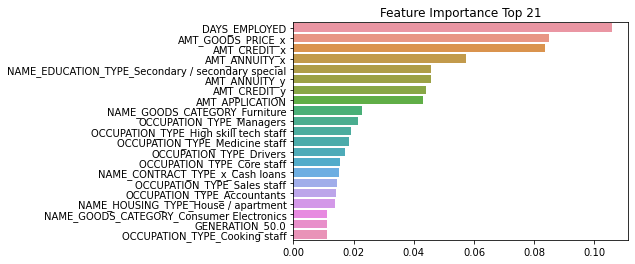

                 FN       FP
Capital        -8.0    -10.0
Insurance      -9.0    -13.0
Prediction  15459.0  44738.0
    Capital  Insurance  Prediction
FN     -8.0       -9.0     15459.0
FP    -10.0      -13.0     44738.0
    Capital  Insurance  Prediction  CapitalExpectedLoss  InsuranceExpectedLoss
FN     -8.0       -9.0     15459.0            -123672.0              -139131.0
FP    -10.0      -13.0     44738.0            -447380.0              -581594.0
-571052.0
-720725.0
                   0              1
count  287783.000000  287783.000000
mean        0.490841       0.509159
std         0.392329       0.392329
min         0.000000       0.000000
25%         0.203163       0.000000
50%         0.335840       0.664160
75%         1.000000       0.796837
max         1.000000       1.000000


In [34]:
DecisionTreeCustom(X = X_smote.drop(["CODE_GENDER_M", "CODE_GENDER_F"], axis = 1),
                   y = y_smote,
                   split_ratio = 0.5, 
                   alpha = 0,
                   depth = 23,
                   impurity = "gini")

##### (4) 변수 중요도에 따른 21차원으로 축소 후 모델 적합

모든 performance measure가 악화하는 문제 발생하여 적절한 대안이 아님을 확인

```
X_reduction_numeric = X.select_dtypes(exclude = ["uint8"])
X_numeric_list = X_reduction_numeric.columns.tolist()

fourBinsDiscretizer = KBinsDiscretizer(n_bins = 5, 
                                       encode = "ordinal",
                                       strategy = "quantile")
  # [연속형 변수를 4개 구간에 따라 범주형 변수로 변환]

X_reduction_numeric = pd.DataFrame(
    fourBinsDiscretizer.fit_transform(X_reduction_numeric),
    columns = X_numeric_list)

X_reduction_dummy = X.loc[
    :, ["NAME_EDUCATION_TYPE_Higher education", 
        "NAME_EDUCATION_TYPE_Secondary / secondary special",
        "NAME_HOUSING_TYPE_House / apartment",
        "ORGANIZATION_TYPE_entity_type",
        "ORGANIZATION_TYPE_Self-employed",
        "ORGANIZATION_TYPE_trade_type",
        "ORGANIZATION_TYPE_Industry_type",
        "NAME_INCOME_TYPE_Working",
        "NAME_INCOME_TYPE_Commercial associate",
        "OCCUPATION_TYPE_Laborers",
        "OCCUPATION_TYPE_Sales staff",
        "CODE_GENDER_M"]]

# X.iloc[:, 0:30].info()
# X.iloc[:, 31:60].info()
# X.iloc[:, 61:90].info()
# X.iloc[:, 91:117].info()

X_reduction = pd.concat(
    [X_reduction_numeric, X_reduction_dummy], axis = 1)
X_reduction = X_reduction.astype("category")
  # [사후 특징 중요도에 따른 특징 선택한 데이터 프레임]

X_dummy = X.select_dtypes(include = ["uint8"])
X_binsDiscretize = pd.concat(
    [X_reduction_numeric, X_dummy], axis = 1)

  # DecisionTreeCustom(X = X_binsDiscretize, split_ratio = 0.2, alpha = 0, depth = 23, impurity = "gini")
    # [연속형 변수를 4분위수에 따라 5구간으로 분리하여 범주형 변수로 변환하는 방식은 성능을 악화시키는 대안]
```

```
# 의사결정트리 시각화 코드

DV_names = np.array(["1", "0"])
IV_names = X.columns.tolist()

plt.figure(figsize = (30, 4))
plot_tree(decisionTreePruned, 
          class_names = DV_names,
          feature_names = IV_names,
          filled = True, 
          max_depth = 3)
plt.title("Tuning Decision Tree")
plt.show()

dtNode = export_text(decisionTreePruned, feature_names = IV_names)
print(dtNode)
```

##### (5) 다수 클래스에서 표본을 소수 클래스 데이터 수로 추출하여 만든 각 모델을 투표 (일종의 ML 버전 Mini Batch)

```
df_NCB = NCB_MICE_FS_OD.drop(["SK_ID_CURR", "SK_ID_PREV"], axis = 1)
df_TARGET_0 = df_NCB[df_NCB["TARGET"] == 0]
df_TARGET_1 = df_NCB[df_NCB["TARGET"] == 1]
```

```
def get_train_batch(df_majority, df_minority, start, end):
    # [다수클래스를 분할한(표본추출한) 12개의 batch를 소수클래스 표본과 df_train으로 병합]
  df_train = pd.concat([df_majority[start : end], df_minority], axis = 0, ignore_index = True)
  
  X_train = df_train.drop("TARGET", axis = 1)
  y_train = df_train["TARGET"]

  return X_train, y_train
```

```
start: int = 0
end: int = len(df_TARGET_1)

while True :
  if end <= len(df_TARGET_0) :
    get_train_batch(df_TARGET_0, df_TARGET_1, start = start, end = end)
    
    start += len(df_TARGET_1)
    end += len(df_TARGET_1)
  else : 
    # end > len(df_TARGET_0)
    break
```

##### (6) 비용 기반 데이터 가중치 부여한 의사결정 트리 (cost-sensitive decision tree)

* 결정 임계치(threshold)에 부여 :  class probability
* 분할 기준(split criteria)에 반영 : log loss = $ \alpha \cdot p \log{p} + (1-p) \log{1-p} $
* 가지치기(pruning)에 반영
* https://github.com/david-cortes/costsensitive



---



#### 2) 나이브 베이지안 분류기 : 가우시안, 베르누이, 범주형

In [37]:
def BinaryNaiveBayes(X: pd.DataFrame, y: pd.Series, smoothing: int, threshold: float):
  
  np.random.seed(2023)
  X_train, X_test, y_train, y_test = train_test_split(X,
                                                      y,
                                                      stratify = y,
                                                      test_size = 0.5,
                                                      random_state = 2023)
  binaryNB = BernoulliNB(
      binarize = 0,
      alpha = smoothing,
      fit_prior = True,
      class_prior = None)
        # [binarize] 특성변수 표본을 이진분류하는 임계값으로 X 독립변수는 더미인코딩하여 0(defalut) 설정 
        # [alpha] 평활화(스무딩) 여부
        # [fit_prior] 사전확률을 균일분포(0,1)을 따르도록 할 것인지 설정
        # [class_prior] 종속변수의 각 클래스별 사전확률 구체화하지 않고 데이터 분포를 따르도록 설정
        
  # target_wt = [weights if target == 1 else 1 for target in y_train]
      # [sample_weight] 클래스 불균형을 4:1로 완화하기 위해 소수클래스에 가중치 3배 부여
      # [Error] is_scalar(key) and isna(key) and not self.hasnans: KeyError: 0
      # [The sample_weight and class_weight are two different things.]
      # [sample_weight] array-like of shape (n_samples,), default = None

  binaryNB.fit(X_train, y_train) 
    # [sample_weight] = target_wt
  y_pred_test = binaryNB.predict(X_test)
  y_pred_train = binaryNB.predict(X_train)
  
  print(dt_eval(y_test, y_pred_test))
  print(dt_eval(y_train, y_pred_train))
  
  y_pred_test = pd.DataFrame(binaryNB.predict_proba(X_test))[1]
  y_pred = y_pred_test.copy()
  y_pred[y_pred > threshold] = 1
  y_pred[y_pred <= threshold] = 0

  y_pred = np.array(y_pred)
  y_test = np.array(y_test)
  
  TP = 0
  FN = 0
  FP = 0
  TN = 0

  for i in range(len(y_pred)):
    if y_test[i] == y_pred[i] == 1:
      TP += 1
    if y_test[i] == 1 and y_pred[i] == 0:
      FN += 1
    if y_test[i] == 0 and y_pred[i] == 1:
      FP += 1
    if y_test[i] == 0 and y_pred[i] == 0:
      TN += 1

  confusionMatrix = np.array([[TP, FN], [FP, TN]]).reshape(2, 2)
  Precision = TP / (TP + FP)
  Recall = TP / (TP + FN)
  F1 = (2*Precision*Recall) / (Precision + Recall)
  F_Beta = ((1+(0.75**2))*Precision*Recall) / ((0.75**2)*Precision + Recall)
  print("정확도 :", (TP + TN) / (TP + FN + FP + TN))
  print("정밀도 :", Precision)
  print("재현율 :", Recall)
  
  # 분류 가중치 테이블
  DBCapital = [2735, 23872]
  DBInsurance = [6981, 488399]
  DBCapital = pd.Series(DBCapital)
  DBInsurance = pd.Series(DBInsurance)
  DBWeights = pd.DataFrame({
      "Capital" : DBCapital,
      "Insurance" : DBInsurance
  }).T
  DBWeights.columns = ["FN", "FP"]

  # 분류 가중치 단위 조정 : 자연로그 변환
  DBWeights_loge = np.log(DBWeights)
  classifyWeights = round(DBWeights_loge, 0)
  classifyWeights = -(classifyWeights)
    # [FN, FP 음수로 치환]
  classifyWeights.at[2,:] = confusionMatrix[[0,1], [1,0]]
    # [confusionMatrix[[0,1], [1,0]] = Prediction(FN, FP의 개수)
  classifyWeights.index = ["Capital", "Insurance", "Prediction"]
  classifyWeights = classifyWeights.transpose()
  classifyWeights["CapitalExpectedLoss"] = classifyWeights["Capital"] * classifyWeights["Prediction"]
  classifyWeights["InsuranceExpectedLoss"] = classifyWeights["Insurance"] * classifyWeights["Prediction"]
    # 행렬곱을 numpy module없이 구현하는 방법 : [[sum(x*Prediction) for x in i] for i in zip(*listcapital, *listinsurance)]
  print(sum(classifyWeights["CapitalExpectedLoss"]), sum(classifyWeights["InsuranceExpectedLoss"]))

In [38]:
BinaryNaiveBayes(X = X_smote.drop(["CODE_GENDER_M", "CODE_GENDER_F"], axis = 1),
                 y = y_smote, smoothing = 1, threshold = 0.5)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


혼동 행렬
[[104635  39257]
 [ 49999  93892]]
정확도: 0.6898496436551151
정밀도: 0.6766623122987183
재현율: 0.7271773274400245
F1: 0.7010109672189357
F-0.75: 0.6940184740839632
None
혼동 행렬
[[104840  39051]
 [ 50175  93717]]
정확도: 0.6899538888676537
정밀도: 0.6763216462922943
재현율: 0.7286070706298517
F1: 0.7014914387800847
F-0.75: 0.6942570032943436
None
정확도 : 0.6898496436551151
정밀도 : 0.6766623122987183
재현율 : 0.7271773274400245
-814046.0 -1003300.0


#### 3) 이항 로지스틱 회귀분석

<ipython-input-39-75332ea6fbf0>:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(correlation, dtype = np.bool)


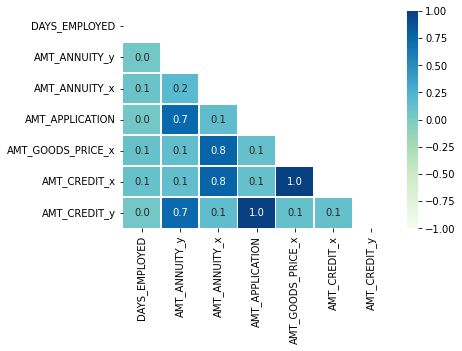

In [39]:
# 피어슨 상관분석

correlation = X_smote.select_dtypes(exclude = "uint8").corr()
mask = np.zeros_like(correlation, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(data = correlation, 
            cmap = "GnBu", 
              # [colormap 팔레트]
            annot = True, 
              # [실제값 표시]
            fmt = "0.01f",
              # [소수점 둘째 자리까지 표시]
            mask = mask, 
              # [표시하지 않을 위쪽 삼각형 마스크 부분 지정]
            linewidths = 0.5, 
              # [경계면 실선으로 구분]
            vmin = -1,
            vmax = 1
              # [colorbar의 범위 -1 ~ 1로 지정]
            )
plt.show()
  # [AMT_CREDIT_x와 AMT_GOODS_PRICE_x의 상관계수 r] = 1
  # [AMT_CREDIT_x와 AMT_APPLICATION의 상관계수 r] = 1

In [57]:
X_num = X_smote.select_dtypes(exclude = ["uint8"])
X_fac = X_smote.select_dtypes(include = ["uint8"])
X_fac = X_fac.astype("category")

scaler = StandardScaler()
  # X_num = X_smote.loc[:, X_smote.select_dtypes(exclude = ["uint8"]).columns] 
X_num = pd.DataFrame(scaler.fit_transform(X_num), columns = X_num.columns)
X_smote_numfac = pd.concat([X_num, X_fac], axis = 1)

In [64]:
def BinaryLogisticRegression():
  
  np.random.seed(2023)
  X_train, X_test, y_train, y_test = train_test_split(X_smote_numfac.drop(["CODE_GENDER_F", "CODE_GENDER_M", "AMT_CREDIT_y", "AMT_GOODS_PRICE_x"], axis = 1),
                                                      y_smote,
                                                      stratify = y_smote,
                                                      test_size = 0.5,
                                                      random_state = 2023)

  # 모델의 회귀계수와 오즈비가 특성변수(IV)의 클래스(DV) 분류 결정에 미치는 영향의 정도 파악
  '''
  logit = sm.Logit(y_train, X_train)
  result = logit.fit()
    # [RuntimeWarning: overflow encountered in exp return 1/(1+np.exp(-X))]
    # [RuntimeWarning: divide by zero encountered in log return np.sum(np.log(self.cdf(q*np.dot(X,params))))]
    # [LinAlgError: Singular matrix]
    
  print(result.params)
  logitCoef = pd.DataFrame(result.params)
  print(logitCoef)
  print(logitCoef.sort_values(ascending = False).iloc[:, 0:20])

  print((1 - np.exp(result.params)) * 100)
    # [편회귀계수(coef)와 오즈비 np.exp(result.params) 계산]
    # [feature(IV)가 TARGET(DV)에 미치는 영향은 (100 * (1 - odds ratio))]

  print(result.summary2())
    # [duplicate 변수를 제외한 나머지 연속형 변수의 영향이 낮은 이유] 표준화(척도/단위 변환)을 수행하지 않았기 때문
    # [변수간 상관관계 등 문제가 발생한 이유 파악하여야 함]
  '''

  # train data로 모델 적합 후 test data로 클래스 분류(예측)
  glm = LogisticRegression()
  glm.fit(X_train, y_train)
  y_pred_test = glm.predict(X_test)
  y_pred_train = glm.predict(X_train)

  print(dt_eval(y_test, y_pred_test))
  print(dt_eval(y_train, y_pred_train))
  
  # print(pd.DataFrame(glm.predict_proba(X_test)).describe())
    # [각 특성변수에 대한 회귀계수의 로그 오즈비(승산비)를 구한 후]
    # [시그모이드 함수를 적용하여 실제 데이터가 해당 클래스에 속할 분류 확률]

In [65]:
BinaryLogisticRegression()
  # [test data에서 F-0.75점수가 82.35%, 정밀도가 87.01%로 성능의 성능을 보이나, 재현율이 75.18%]
  # [모델은 극단적인 분류기로 이항분포의 확률밀도함수에서 추정한 모수인 y 평균과 y 분산 대비]
  # [실제 데이터 x_i의 분산은 훨씬 큰 값으로 과분산 문제가 발생하여]
  # [제1종 오류를 야기함으로써 재현율이 다른 모델 대비 현저히 낮아지는 결과 도출]

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


혼동 행렬
[[108171  35721]
 [ 16144 127747]]
정확도: 0.8197774017228259
정밀도: 0.8701363471825604
재현율: 0.7517513134851138
F1: 0.8066232424955352
F-0.75: 0.823452803047927
None
혼동 행렬
[[108515  35376]
 [ 16237 127655]]
정확도: 0.8206530615081502
정밀도: 0.869845774015647
재현율: 0.7541472364498127
F1: 0.8078751354027465
F-0.75: 0.824318735868876
None


In [66]:
-8*35721 -10*16144, -9*35721 -13*16144 

(-447208, -531361)

In [67]:
# BinaryLogisticClassifier()
# threshold를 0.5보다 낮게 조정하는 이항 로지스틱 회귀분석 적합함수

def BinaryLogisticClassifier(X: pd.DataFrame, y: pd.Series, threshold: float):
  
  np.random.seed(2023)
  X_train, X_test, y_train, y_test = train_test_split(X,
                                                      y,
                                                      stratify = y,
                                                      test_size = 0.5,
                                                      random_state = 2023)
  glm = LogisticRegression()
  glm.fit(X_train, y_train)
  y_pred_test = pd.DataFrame(glm.predict_proba(X_test))[1]

  y_pred = y_pred_test.copy()
  y_pred[y_pred > threshold] = 1
  y_pred[y_pred <= threshold] = 0

  print(dt_eval(y_test, y_pred))

In [70]:
BinaryLogisticClassifier(X = X_smote_numfac.drop(["CODE_GENDER_F", "CODE_GENDER_M", "AMT_CREDIT_y", "AMT_GOODS_PRICE_x"], axis = 1), 
                         y = y_smote, threshold = 0.4)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


혼동 행렬
[[118561  25331]
 [ 29474 114417]]
정확도: 0.8095613708940417
정밀도: 0.8008984361806329
재현율: 0.8239582464626247
F1: 0.8122647100131196
F-0.75: 0.8090497621457435
None




---



#### 4) 서포트 벡터 머신

* 파이썬을 이용한 통계적 머신러닝 제3판에 따르면 SVM Classifier는 빅데이터 분석에 적합하지 않다는 의견이 있으나 근거는 시간복잡도가 높아 수일간 모델 적합 실패로 들고 있는바 채택하지 않는다. 

* 사상된 고차원(n차원) 공간에서의 (n-1)차원의 부분공간, 초평면(결정 경계)으로 전체 공간을 두 개의 공간으로 분할(클래스 분류)

* 마진 최대화 : 초평면 h(x)로부터 가장 가까이 있는 데이터까지의 거리를 최대화

  마진이 클수록 클래스를 분류하는 경계선이 더욱 안정적이라고 보는 관점

  $ hyper plane, h(x) = w^T \cdot x + w_0 = 0 $

  $ y = 1(class), w^T cdot x_1 + w_0 = 1 $

  $ y = -1(class), w^T cdot x_2 + w_0 = -1 $

  $ sgn(u) = \begin{cases} 1 &{u \geq 0} \\ -1 &{u < 0} \end{cases} $ 

 각 $ x_i$에 대한 클래스 분류를 나타내는 $ y_i = sgn( h(x_i) ) $ 

 올바른 분류는 $ y_ih(x_i) > 0 $이며, 마진 최대화하는 식은 $ d_i = y_i \frac{h(x_i)}{||w||}, min_i \ d_i, argmax_{w, w_0} \frac{1}{||w||} $

* 커널 함수
  
  선형 커널 $ k(x, y) = x^Ty $

  다항식 커널 $ k(x, y) = (\Upsilon x^Ty + c)^d $

  가우시안 터널(rbf) $ k(x, y) = exp(-\Upsilon ||x - y||^2) $

  시그모이드 커널 $ k(x, y) = tanh (\Upsilon x^Ty + c)^d $

  그밖에 라플라시안 커널, 카이제곱 커널 등이 있으며, 스스로 커스텀하여 커널을 사용하는 것도 사이킷런은 인정하고 있다.  

In [80]:
def SupportVectorClassification(X: pd.DataFrame, 
                                y: pd.Series):
  
  np.random.seed(2023)
    # [Warning] Consider pre-processing your data with StandardScaler or MinMaxScaler.

  X_train, X_test, y_train, y_test = train_test_split(X,
                                                      y,
                                                      stratify = y,
                                                      test_size = 0.5,
                                                      random_state = 2023)
  '''
  svm_param = {"kernel" : ("linear", "rbf"),
               "C" : [0.01, 0.05, 0.1],
               "gamma" : [0.01, 0.05, 0.1]}
    # [{'C': 0.001, 'gamma': 0.001, 'kernel': 'rbf'}] f-beta score : 0.6098

  supportVectorMachine = svm.SVC(probability = True,
                                 max_iter = 1,
                                 verbose = False,
                                 random_state = 2023)
    # [하이퍼파라미터 : 서포트 벡터 마진의 비용(Cost)] hard margin or soft margin
    # [커널 함수] linear, poly(nomial lm), rbf(normal dist)
    # [decision_function_shape] ovo, ovr(one vs rest)

  f_beta = make_scorer(fbeta_score, beta = 1.35)
  k_fold = StratifiedKFold(n_splits = 5, random_state = 2023, shuffle = True)
  svm_gridSearch = GridSearchCV(supportVectorMachine,
                                svm_param,
                                scoring = f_beta,
                                cv = k_fold)
  svm_gridSearch.fit(X_train, y_train)
  print(svm_gridSearch.best_score_)
  print(svm_gridSearch.best_params_)
  '''

  svm_fitted = svm.SVC(C = 0.01,
                       gamma = 0.01,
                       kernel = "linear",
                       decision_function_shape = "ovo",
                       probability = True,
                       max_iter = 1,
                       verbose = False,
                       random_state = 2023)
  
  # 서포트 벡터 머신 분류기의 결정 영역에 맞추어 시각화
  '''
  fig, axes = plt.subplots(1, 2, figsize = (12, 8), sharex = True, sharey = True)
  plot_decision_regions(X_train, y_train, clf = svm_fitted, res = 0.02, ax = axes[0], legend = 2)
  axes[0].set_xlabel("Training Data")
  plot_decision_regions(X_test, y_test, clf = svm_fitted , res = 0.02, ax = axes[1], legend = 2)
  axes[1].set_xlabel("Test Data")
  '''

  # 최적화된 하이퍼파라미터로 적합한 서포트 벡터 머신
  svm_fitted.fit(X_train, y_train)
  y_pred = svm_fitted.predict(X_test)
  y_pred = np.array(y_pred)
  y_test = np.array(y_test)
  
  TP = 0
  FN = 0
  FP = 0
  TN = 0

  for i in range(len(y_pred)):
    if y_test[i] == y_pred[i] == 1:
      TP += 1
    if y_test[i] == 1 and y_pred[i] == 0:
      FN += 1
    if y_test[i] == 0 and y_pred[i] == 1:
      FP += 1
    if y_test[i] == 0 and y_pred[i] == 0:
      TN += 1

  confusionMatrix = np.array([[TP, FN], [FP, TN]]).reshape(2, 2)
  print(confusionMatrix)
  Precision = TP / (TP + FP)
  Recall = TP / (TP + FN)
  print("정확도 :", (TP + TN) / (TP + FN + FP + TN))
  print("정밀도 :", Precision)
  print("재현율 :", Recall)
  print("F-Beta 점수 :", ((1+(0.75**2))*Precision*Recall) / ((0.75**2)*Precision + Recall))

  # 분류 가중치 테이블
  DBCapital = [2735, 23872]
  DBInsurance = [6981, 488399]
  DBCapital = pd.Series(DBCapital)
  DBInsurance = pd.Series(DBInsurance)
  DBWeights = pd.DataFrame({
      "Capital" : DBCapital,
      "Insurance" : DBInsurance
  }).T
  DBWeights.columns = ["FN", "FP"]
  DBWeights

  # 분류 가중치 단위 조정 : 자연로그 변환
  DBWeights_loge = np.log(DBWeights)
  classifyWeights = round(DBWeights_loge, 0)
  classifyWeights = -(classifyWeights)
    # [FN, FP 음수로 치환]
  classifyWeights.at[2,:] = confusionMatrix[[0,1], [1,0]]
    # [confusionMatrix[[0,1], [1,0]] = Prediction(FN, FP의 개수)
  classifyWeights.index = ["Capital", "Insurance", "Prediction"]
  print(classifyWeights)
  
  classifyWeights = classifyWeights.transpose()
  print(classifyWeights)

  classifyWeights["CapitalExpectedLoss"] = classifyWeights["Capital"] * classifyWeights["Prediction"]
  classifyWeights["InsuranceExpectedLoss"] = classifyWeights["Insurance"] * classifyWeights["Prediction"]
  print(classifyWeights)

  print(sum(classifyWeights["CapitalExpectedLoss"]))
  print(sum(classifyWeights["InsuranceExpectedLoss"]))

In [82]:
SupportVectorClassification(X = X_smote_numfac.drop(["CODE_GENDER_F", "CODE_GENDER_M"], axis = 1), 
                            y = y_smote)
  # AttributeError: 'GridSearchCV' object has no attribute 'best_clf'
  # 0.7339530713629481, {'C': 0.01, 'gamma': 0.01, 'kernel': 'linear'}

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[[141601   2291]
 [140441   3450]]
정확도 : 0.5040290774646174
정밀도 : 0.5020564313116486
재현율 : 0.9840783365301754
F-Beta 점수 : 0.6095399211391772
                FN        FP
Capital       -8.0     -10.0
Insurance     -9.0     -13.0
Prediction  2291.0  140441.0
    Capital  Insurance  Prediction
FN     -8.0       -9.0      2291.0
FP    -10.0      -13.0    140441.0
    Capital  Insurance  Prediction  CapitalExpectedLoss  InsuranceExpectedLoss
FN     -8.0       -9.0      2291.0             -18328.0               -20619.0
FP    -10.0      -13.0    140441.0           -1404410.0             -1825733.0
-1422738.0
-1846352.0


#### 5) Bagging Ensemble : Random Forest

In [83]:
def RF(max_leaf: float, estimators: float, threshold: float):
  np.random.seed(2023)
  X_train, X_test, y_train, y_test = train_test_split(X_smote.drop(["CODE_GENDER_M", "CODE_GENDER_F"], axis =1),
                                                      y_smote,
                                                      stratify = y_smote,
                                                      random_state = 2023,
                                                      test_size = 0.5)
  
  RandomForest = RandomForestClassifier(random_state = 2023,
                                        max_depth = 23,
                                        criterion = "gini",
                                        max_features = "sqrt",
                                        max_leaf_nodes = max_leaf,
                                        n_estimators = estimators)
  RandomForestClassifier()
  RandomForest.fit(X_train, y_train)
  y_pred_test = pd.DataFrame(RandomForest.predict_proba(X_test))[1]
  y_pred = y_pred_test.copy()
  y_pred[y_pred > threshold] = 1
  y_pred[y_pred <= threshold] = 0

  y_pred = np.array(y_pred)
  y_test = np.array(y_test)
  
  TP = 0
  FN = 0
  FP = 0
  TN = 0

  for i in range(len(y_pred)):
    if y_test[i] == y_pred[i] == 1:
      TP += 1
    if y_test[i] == 1 and y_pred[i] == 0:
      FN += 1
    if y_test[i] == 0 and y_pred[i] == 1:
      FP += 1
    if y_test[i] == 0 and y_pred[i] == 0:
      TN += 1

  confusionMatrix = np.array([[TP, FN], [FP, TN]]).reshape(2, 2)
  print(confusionMatrix)

  Precision = TP / (TP + FP)
  Recall = TP / (TP + FN)
  F1 = (2*Precision*Recall) / (Precision + Recall)
  F_Beta = ((1+(0.75**2))*Precision*Recall) / ((0.75**2)*Precision + Recall)
  print("정확도 :", (TP + TN) / (TP + FN + FP + TN))
  print("정밀도 :", Precision)
  print("재현율 :", Recall)
  print("F-Beta 점수 :", ((1+(0.75**2))*Precision*Recall) / ((0.75**2)*Precision + Recall))

  # 상위 30개 특성변수 중요도 플롯 시각화
  dt_series = pd.Series(RandomForest.feature_importances_, index = X_smote.drop(["CODE_GENDER_F", "CODE_GENDER_M"], axis = 1).columns)
  dt_top_30 = dt_series.sort_values(ascending=False)[:30]
  plt.title("Feature Importance Top 30")
  sns.barplot(x = dt_top_30, y = dt_top_30.index)
  plt.show()

  # 분류 가중치 테이블
  DBCapital = [2735, 23872]
  DBInsurance = [6981, 488399]
  DBCapital = pd.Series(DBCapital)
  DBInsurance = pd.Series(DBInsurance)
  DBWeights = pd.DataFrame({
      "Capital" : DBCapital,
      "Insurance" : DBInsurance
  }).T
  DBWeights.columns = ["FN", "FP"]

  # 분류 가중치 단위 조정 : 자연로그 변환
  DBWeights_loge = np.log(DBWeights)
  classifyWeights = round(DBWeights_loge, 0)
  classifyWeights = -(classifyWeights)
    # [FN, FP 음수로 치환]
  classifyWeights.at[2,:] = confusionMatrix[[0,1], [1,0]]
    # [confusionMatrix[[0,1], [1,0]] = Prediction(FN, FP의 개수)
  classifyWeights.index = ["Capital", "Insurance", "Prediction"]
  classifyWeights = classifyWeights.transpose()
  classifyWeights["CapitalExpectedLoss"] = classifyWeights["Capital"] * classifyWeights["Prediction"]
  classifyWeights["InsuranceExpectedLoss"] = classifyWeights["Insurance"] * classifyWeights["Prediction"]
  
  print(sum(classifyWeights["CapitalExpectedLoss"]), sum(classifyWeights["InsuranceExpectedLoss"]))

<ipython-input-83-02de3e267999>:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RandomForest.fit(X_train, y_train)


[[131782  12110]
 [ 32235 111656]]
정확도 : 0.8459082016658385
정밀도 : 0.8034654944304553
재현율 : 0.9158396575209184
F-Beta 점수 : 0.8405965350955528


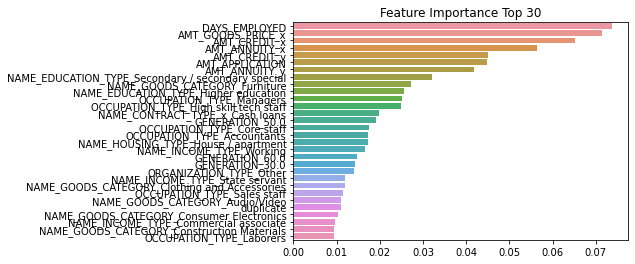

-419230.0 -528045.0


In [84]:
RF(max_leaf = None, estimators = 100, threshold = 0.5)

#### 6) Boosting Ensemble : Light GBM

* 트리의 균형을 맞추지 않고, 최대 예측오류 손실값을 가지는 리프 노드를 분할하여 비대칭적인 규칙의 트리를 생성
* https://lightgbm.readthedocs.io/en/latest/_modules/lightgbm/plotting.html#plot_importance
* permutation importance는 특정 feature를 무작위로 섞어 성능 손실에 얼만큼 영향을 주는지 계산하며, 해당 feature를 제외할 경우 성능이 상당히 악화되면 중요도 높은 변수로 해석

In [95]:
def LightGradientBoostingTree(X: pd.DataFrame, y: pd.Series, boostMethod: object, threshold: float):
  # [boosting_type] "gbdt(xgboost의 gbtree)", "dart(xgboost)", "goss", "rf"
  
  np.random.seed(2023)
  X_train, X_test, y_train, y_test = train_test_split(X,
                                                      y,
                                                      stratify = y,
                                                      test_size = 0.5,
                                                      random_state = 2023)
  lgbTree = LGBMClassifier(n_estimators = 100,
                           max_depth = 23,
                           boosting_type = boostMethod,
                           learning_rate = 0.5,
                           random_state = 2023)
  
  lgbTree.fit(X_train, y_train)
  
  # y_pred = lgbTree.predict(X_test)
  y_pred_test = pd.DataFrame(lgbTree.predict_proba(X_test))[1]
  y_pred = y_pred_test.copy()
  y_pred[y_pred > threshold] = 1
  y_pred[y_pred <= threshold] = 0

  y_pred = np.array(y_pred)
  y_test = np.array(y_test)
  
  TP = 0
  FN = 0
  FP = 0
  TN = 0

  for i in range(len(y_pred)):
    if y_test[i] == y_pred[i] == 1:
      TP += 1
    if y_test[i] == 1 and y_pred[i] == 0:
      FN += 1
    if y_test[i] == 0 and y_pred[i] == 1:
      FP += 1
    if y_test[i] == 0 and y_pred[i] == 0:
      TN += 1

  confusionMatrix = np.array([[TP, FN], [FP, TN]]).reshape(2, 2)
  print(confusionMatrix)
  Precision = TP / (TP + FP)
  Recall = TP / (TP + FN)
  print("정확도 :", (TP + TN) / (TP + FN + FP + TN))
  print("정밀도 :", Precision)
  print("재현율 :", Recall)
  print("F-Beta 점수 :", ((1+(0.75**2))*Precision*Recall) / ((0.75**2)*Precision + Recall))

  # 특징 중요도 : "split" or "gain" 빈도, feature의 split에 대한 기여도
  plot_importance(lgbTree, max_num_features = 30)
  plt.show
  
  # 분류 가중치 테이블
  DBCapital = [2735, 23872]
  DBInsurance = [6981, 488399]
  DBCapital = pd.Series(DBCapital)
  DBInsurance = pd.Series(DBInsurance)
  DBWeights = pd.DataFrame({
      "Capital" : DBCapital,
      "Insurance" : DBInsurance
  }).T
  DBWeights.columns = ["FN", "FP"]
  DBWeights

  # 분류 가중치 단위 조정 : 자연로그 변환
  DBWeights_loge = np.log(DBWeights)
  classifyWeights = round(DBWeights_loge, 0)
  classifyWeights = -(classifyWeights)
    # [FN, FP 음수로 치환]
  classifyWeights.at[2,:] = confusionMatrix[[0,1], [1,0]]
    # [confusionMatrix[[0,1], [1,0]] = Prediction(FN, FP의 개수)
  classifyWeights.index = ["Capital", "Insurance", "Prediction"]
  print(classifyWeights)
  
  classifyWeights = classifyWeights.transpose()
  print(classifyWeights)

  classifyWeights["CapitalExpectedLoss"] = classifyWeights["Capital"] * classifyWeights["Prediction"]
  classifyWeights["InsuranceExpectedLoss"] = classifyWeights["Insurance"] * classifyWeights["Prediction"]
  print(classifyWeights)
    # 행렬곱을 numpy module없이 구현하는 방법 : [[sum(x*Prediction) for x in i] for i in zip(*listcapital, *listinsurance)]

  print(sum(classifyWeights["CapitalExpectedLoss"]))
  print(sum(classifyWeights["InsuranceExpectedLoss"]))

  lgbTreeProb = lgbTree.predict_proba(X_test)
  print(pd.DataFrame(lgbTreeProb).describe())
    # [분류 확률의 분포 출력]

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[[123324  20568]
 [ 12219 131672]]
정확도 : 0.8860704072165486
정밀도 : 0.9098514862442177
재현율 : 0.8570594612626137
F-Beta 점수 : 0.890113392668452
                 FN       FP
Capital        -8.0    -10.0
Insurance      -9.0    -13.0
Prediction  20568.0  12219.0
    Capital  Insurance  Prediction
FN     -8.0       -9.0     20568.0
FP    -10.0      -13.0     12219.0
    Capital  Insurance  Prediction  CapitalExpectedLoss  InsuranceExpectedLoss
FN     -8.0       -9.0     20568.0            -164544.0              -185112.0
FP    -10.0      -13.0     12219.0            -122190.0              -158847.0
-286734.0
-343959.0
                  0              1
count  2.877830e+05  287783.000000
mean   5.003255e-01       0.499674
std    3.758071e-01       0.375807
min    3.090247e-07       0.000381
25%    6.787737e-02       0.121663
50%    5.615029e-01       0.438497
75%    8.783370e-01       0.932123
max    9.996189e-01       1.000000


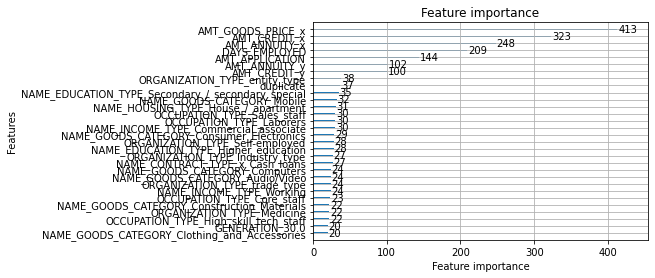

In [96]:
LightGradientBoostingTree(X = X_smote.drop(["CODE_GENDER_M", "CODE_GENDER_F"], axis = 1),
                          y = y_smote, boostMethod = "gbdt", threshold = 0.5)
  # [연체로 예측된 고객 100명 중 실제 연체 고객이 90명인 경우]
  # [실제 연체 고객이 100명 중 연체로 예측된 고객이 85명인 경우]

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[[119860  24032]
 [  9283 134608]]
정확도 : 0.884235691475869
정밀도 : 0.9281184423468558
재현율 : 0.8329858504989853
F-Beta 점수 : 0.8914663185490445
                 FN      FP
Capital        -8.0   -10.0
Insurance      -9.0   -13.0
Prediction  24032.0  9283.0
    Capital  Insurance  Prediction
FN     -8.0       -9.0     24032.0
FP    -10.0      -13.0      9283.0
    Capital  Insurance  Prediction  CapitalExpectedLoss  InsuranceExpectedLoss
FN     -8.0       -9.0     24032.0            -192256.0              -216288.0
FP    -10.0      -13.0      9283.0             -92830.0              -120679.0
-285086.0
-336967.0
                  0              1
count  2.877830e+05  287783.000000
mean   5.003255e-01       0.499674
std    3.758071e-01       0.375807
min    3.090247e-07       0.000381
25%    6.787737e-02       0.121663
50%    5.615029e-01       0.438497
75%    8.783370e-01       0.932123
max    9.996189e-01       1.000000


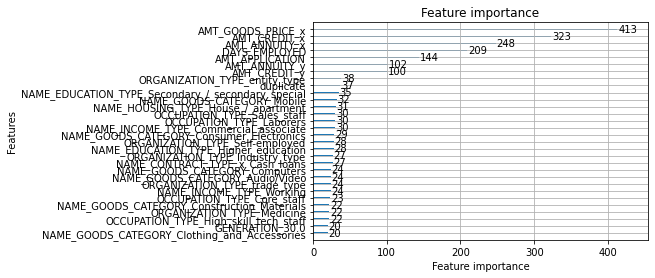

In [117]:
LightGradientBoostingTree(X = X_smote.drop(["CODE_GENDER_M", "CODE_GENDER_F"], axis = 1),
                          y = y_smote, boostMethod = "gbdt", threshold = 0.55)

In [130]:
def LightGradientBoostingTreeThreshold(X: pd.DataFrame, 
                                       y: np.array, 
                                       boostMethod: object,
                                       threshold: float):
  # [boosting_type] "gbdt(xgboost의 gbtree)", "dart(xgboost)", "goss", "rf"
  
  np.random.seed(2023)
  X_train, X_test, y_train, y_test = train_test_split(X,
                                                      y,
                                                      stratify = y,
                                                      test_size = 0.5,
                                                      random_state = 2023)
  lgbTree = LGBMClassifier(n_estimators = 100,
                           max_depth = 23,
                           boosting_type = boostMethod,
                           learning_rate = 0.5,
                           random_state = 2023)
  lgbTree.fit(X_train, y_train)
  
  # y_pred = lgbTree.predict(X_test) 학습시킨 모델에 X_test data 적용하여 예측
  y_pred_test = pd.DataFrame(lgbTree.predict_proba(X_test))[1]
  y_pred = y_pred_test.copy()
  y_pred[y_pred > threshold] = 1
  y_pred[y_pred <= threshold] = 0

  y_pred = np.array(y_pred)
  y_test = np.array(y_test)
  
  # 혼동행렬(채점표) 작성
  TP = 0
  FN = 0
  FP = 0
  TN = 0

  for i in range(len(y_pred)):
    if y_test[i] == y_pred[i] == 1:
      TP += 1
    if y_test[i] == 1 and y_pred[i] == 0:
      FN += 1
    if y_test[i] == 0 and y_pred[i] == 1:
      FP += 1
    if y_test[i] == 0 and y_pred[i] == 0:
      TN += 1

  confusionMatrix = np.array([[TP, FN], [FP, TN]]).reshape(2, 2)

  # F-0.75 점수(Beta = 0.75) 계산
  Precision = TP / (TP + FP)
  Recall = TP / (TP + FN)
  F_Beta = ((1+(0.75**2))*Precision*Recall) / ((0.75**2)*Precision + Recall)
  
  # 분류 가중치 테이블
  DBCapital = [2735, 23872]
  DBInsurance = [6981, 488399]
  DBCapital = pd.Series(DBCapital)
  DBInsurance = pd.Series(DBInsurance)
  DBWeights = pd.DataFrame({
      "Capital" : DBCapital,
      "Insurance" : DBInsurance
  }).T
  DBWeights.columns = ["FN", "FP"]

  # 분류 가중치 단위 조정 : 자연로그 변환
  DBWeights_loge = np.log(DBWeights)
  classifyWeights = round(DBWeights_loge, 0)
  classifyWeights = -(classifyWeights)
    # [FN, FP 음수로 치환]
  classifyWeights.at[2,:] = confusionMatrix[[0,1], [1,0]]
    # [confusionMatrix[[0,1], [1,0]] = Prediction(FN, FP의 개수)
  classifyWeights.index = ["Capital", "Insurance", "Prediction"]
  classifyWeights = classifyWeights.transpose()
  classifyWeights["CapitalExpectedLoss"] = classifyWeights["Capital"] * classifyWeights["Prediction"]
  classifyWeights["InsuranceExpectedLoss"] = classifyWeights["Insurance"] * classifyWeights["Prediction"]
    # 행렬곱을 numpy module없이 구현하는 방법 : [[sum(x*Prediction) for x in i] for i in zip(*listcapital, *listinsurance)]
  
  return F_Beta, sum(classifyWeights["CapitalExpectedLoss"]), sum(classifyWeights["InsuranceExpectedLoss"])

In [131]:
# 분류 임계값(class probability, decision threshold, cutoff)에 대하여 0.01:0.99까지 0.01씩 증가하는 수열(리스트 내 99개의 원소) 설정

contain: List = []
float: float = 0.01

while float:
  if float < 1:
    contain.append(float)
    float = float + 0.01
    float = round(float, 3)
  else:
    # float = 1
    break

# 길이 99의 빈 벡터(리스트) 생성 
vector = list(np.zeros(shape = 99))

# 임계값에 따른 성능평가지표(가중치 조정한 정밀도와 재현율의 조화평균과 각 금융회사의 오분류비용(예측 기대손실)) 데이터 프레임 생성
Threshold_Metric_curve = pd.DataFrame(data = np.array([contain, vector, vector, vector]).reshape(4, 99).T,
                                      columns = ["Threshold", "F_Beta_score", "Capital_Expected_Loss", "Insurance_Expected_Loss"])
Threshold_Metric_curve

,Threshold,F_Beta_score,Capital_Expected_Loss,Insurance_Expected_Loss
0,0.01,0.0,0.0,0.0
1,0.02,0.0,0.0,0.0
2,0.03,0.0,0.0,0.0
3,0.04,0.0,0.0,0.0
4,0.05,0.0,0.0,0.0
...,...,...,...,...
94,0.95,0.0,0.0,0.0
95,0.96,0.0,0.0,0.0
96,0.97,0.0,0.0,0.0
97,0.98,0.0,0.0,0.0


In [132]:
y_smote = np.array(y_smote)
type(y_smote)
  # [실제 데이터를 활용한 종속변수 TARGET 생성 시] 
  # [코리안크레딧뷰로/신용정보원 기준 신용평점 630점 미만인 고객]
  # [과거(1년 이내) 채무연체 이력 / 현재 연체보유 이력이 있는 고객]

numpy.ndarray

In [133]:
# Light GBM의 분류확률 임계값 수열(0.01:0.99)에 따른 LightGBM 모델성능평가지표를 데이터프레임에 저장

i: int = 0
  # [index 정수형 타입 선언 후 0 할당(초기화)]

for float in contain:
  globals()["F_Beta_{}".format(i)], globals()["Capital_Loss_{}".format(i)], globals()["Insurance_Loss_{}".format(i)] = LightGradientBoostingTreeThreshold(
    X = X_smote.drop(["CODE_GENDER_M", "CODE_GENDER_F"], axis = 1), 
    y = y_smote, 
    boostMethod = "gbdt", 
    threshold = float)
  
  Threshold_Metric_curve.iloc[i, 1] = globals()["F_Beta_{}".format(i)]
  Threshold_Metric_curve.iloc[i, 2] = globals()["Capital_Loss_{}".format(i)]
  Threshold_Metric_curve.iloc[i, 3] = globals()["Insurance_Loss_{}".format(i)]

  i += 1
  
Threshold_Metric_curve.to_csv("/content/drive/MyDrive/threshold_metric.csv",
                              sep = ",",
                              na_rep = "NaN",
                              float_format = "%.4f",
                              index = False)

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), fo

In [134]:
# 빠른 재현성을 위한 csv 파일을 구글드라이브에 저장 후 로드

# Threshold_Metric_curve = pd.read_csv("/content/drive/MyDrive/threshold_metric.csv", index_col = False)
print(max(Threshold_Metric_curve["F_Beta_score"]), max(Threshold_Metric_curve["Capital_Expected_Loss"]), max(Threshold_Metric_curve["Insurance_Expected_Loss"]))

0.8914663185490445 -284774.0 -336892.0


In [135]:
# Default threshold인 0.5일 때 성능평가지표
print(Threshold_Metric_curve[Threshold_Metric_curve["Threshold"] == 0.5])

# F-0.75점수가 최대가 되는 임계값 = 0.55
print(Threshold_Metric_curve[Threshold_Metric_curve["F_Beta_score"] == max(Threshold_Metric_curve["F_Beta_score"])])

# DB캐피탈의 오분류비용이 최소가 되는 임계값 = 0.55
print(Threshold_Metric_curve[Threshold_Metric_curve["Capital_Expected_Loss"] == max(Threshold_Metric_curve["Capital_Expected_Loss"])])

# DB손해보험의 오분류비용이 최소가 되는 임계값 = 0.56
print(Threshold_Metric_curve[Threshold_Metric_curve["Insurance_Expected_Loss"] == max(Threshold_Metric_curve["Insurance_Expected_Loss"])])

    Threshold  F_Beta_score  Capital_Expected_Loss  Insurance_Expected_Loss
49        0.5      0.890113              -286734.0                -343959.0
    Threshold  F_Beta_score  Capital_Expected_Loss  Insurance_Expected_Loss
54       0.55      0.891466              -285086.0                -336967.0
    Threshold  F_Beta_score  Capital_Expected_Loss  Insurance_Expected_Loss
53       0.54      0.891448              -284774.0                -337617.0
    Threshold  F_Beta_score  Capital_Expected_Loss  Insurance_Expected_Loss
55       0.56      0.891297              -285836.0                -336892.0


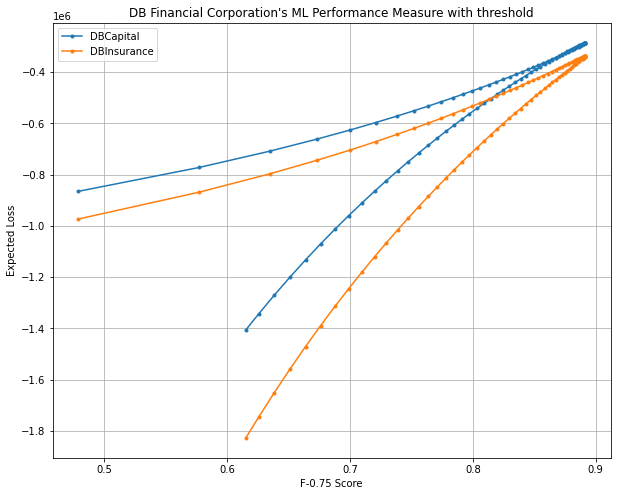

In [136]:
plt.figure(figsize = (10, 8))
plt.plot(Threshold_Metric_curve["F_Beta_score"], Threshold_Metric_curve["Capital_Expected_Loss"], marker = "o", markersize = 3)
plt.plot(Threshold_Metric_curve["F_Beta_score"], Threshold_Metric_curve["Insurance_Expected_Loss"], marker = "o", markersize = 3)
plt.xlabel("F-0.75 Score")
plt.ylabel("Expected Loss")
plt.legend(["DBCapital", "DBInsurance"])
plt.title("DB Financial Corporation's ML Performance Measure with threshold")
plt.grid()
plt.show()

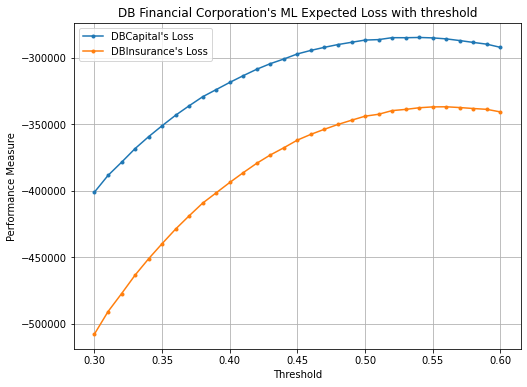

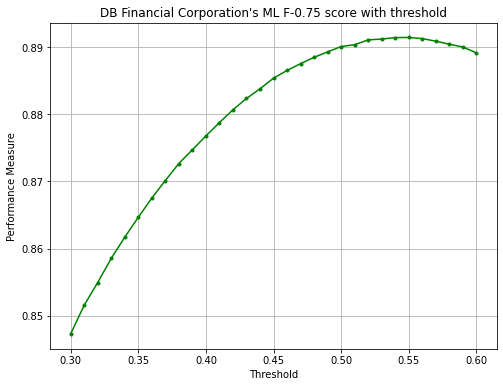

In [137]:
# f, axes = plt.subplots(ncols = 2, figsize = (12, 8))

plt.figure(figsize = (8, 6))
plt.plot(Threshold_Metric_curve.iloc[29:60, :]["Threshold"], Threshold_Metric_curve.iloc[29:60, :]["Capital_Expected_Loss"], marker = "o", markersize = 3)
plt.plot(Threshold_Metric_curve.iloc[29:60, :]["Threshold"], Threshold_Metric_curve.iloc[29:60, :]["Insurance_Expected_Loss"], marker = "o", markersize = 3)
plt.xlabel("Threshold")
plt.ylabel("Performance Measure")
plt.legend(["DBCapital's Loss", "DBInsurance's Loss"])
plt.title("DB Financial Corporation's ML Expected Loss with threshold")
plt.grid()
plt.show()

plt.figure(figsize = (8, 6))
plt.plot(Threshold_Metric_curve.iloc[29:60, :]["Threshold"], Threshold_Metric_curve.iloc[29:60, :]["F_Beta_score"], color = "green", marker = "o", markersize = 3)
plt.xlabel("Threshold")
plt.ylabel("Performance Measure")
plt.title("DB Financial Corporation's ML F-0.75 score with threshold")
plt.grid()
plt.show()

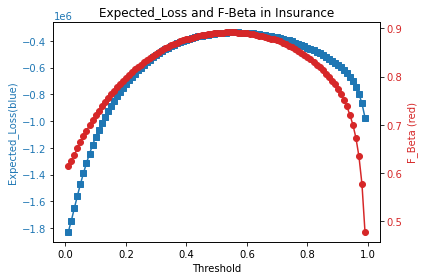

In [138]:
# 기술지표와 사업지표에 따른 최종 비용곡선 시각화

fig, ax1 = plt.subplots()
color_1 = 'tab:blue'
ax1.set_title('Expected_Loss and F-Beta in Insurance')
ax1.set_xlabel('Threshold')
ax1.set_ylabel("Expected_Loss(blue)", color = color_1)
ax1.plot(Threshold_Metric_curve.Threshold, Threshold_Metric_curve.Insurance_Expected_Loss, marker = 's', color = color_1)
ax1.tick_params(axis='y', labelcolor = color_1)

ax2 = ax1.twinx()
color_2 = "tab:red"
ax2.set_ylabel("F_Beta (red)", color = color_2)
ax2.plot(Threshold_Metric_curve.Threshold, Threshold_Metric_curve.F_Beta_score, marker = 'o', color = color_2)
ax2.tick_params(axis = 'y', labelcolor = color_2)

fig.tight_layout()
plt.show()

#### 7) 원본 검증용 데이터에서 신용대출채권 연체 또는 손상이 예측된 위험고객(TP) 데이터 분할

In [118]:
def LightGradientBoostingTreeRisk(X: pd.DataFrame, 
                                  y: pd.Series, 
                                  boostMethod: object,
                                  threshold: float):
  # [boosting_type] "gbdt(xgboost의 gbtree)", "dart(xgboost)", "goss", "rf"
  
  np.random.seed(2023)
  X_train, X_test, y_train, y_test = train_test_split(X,
                                                      y,
                                                      stratify = y,
                                                      test_size = 0.5,
                                                      random_state = 2023)
  # X_test.sort_index(ascending = True, inplace = True)
  X_test.reset_index(drop = True, inplace = True)
    # [특성 벡터의 검증용 데이터 셋 행번호(인덱스) 초기화]
  
  lgbTree = LGBMClassifier(n_estimators = 100,
                           max_depth = 23,
                           boosting_type = boostMethod,
                           learning_rate = 0.5,
                           random_state = 2023)
  lgbTree.fit(X_train, y_train)
  
  # y_pred = lgbTree.predict(X_test) 학습시킨 모델에 X_test data 적용하여 예측
  y_pred_test = pd.DataFrame(lgbTree.predict_proba(X_test))[1]
  y_pred = y_pred_test.copy()
  y_pred[y_pred > threshold] = 1
  y_pred[y_pred <= threshold] = 0

  y_pred = np.array(y_pred)
  y_test = np.array(y_test)
  
  # 신용 리스크 예측 고객 인덱스 번호를 리스트에 저장
  creditRisk_index: List = []
  stableCredit_index: List = []

  for i in range(len(y_test)):
    if y_test[i] == y_pred[i] == 1:
      # [TP]
      creditRisk_index.append(i)
    elif y_test[i] == y_pred[i] == 0:
      # [TN]
      stableCredit_index.append(i)
    else:
      continue
  
  # 신용 리스크 예측 고객, 우량 또는 중신용고객의 데이터 반환
  creditRisk_client = X_test.iloc[creditRisk_index, :]

  # total_index = list(range(0, len(y_test), 1))
  # stableCredit_index = np.setdiff1d(total_index, creditRisk_index)
    # [전체 인덱스 - 리스크 인덱스 = 차집합 인덱스] IndexError: positional indexers are out-of-bounds
  stableCredit_client = X_test.iloc[stableCredit_index, :]
  
  # X_test.drop(creditRisk_index, axis = 0, inplace = True)
    # [이미 삭제된 컬럼인데 다시 삭제하려고 해서 KeyError 발생] KeyError: '[1, 7, 22 ... 287769, 287774, 287781] not found in axis'

  '''
    if mask.any():
       if errors != "ignore":
          raise KeyError(f"{labels[mask]} not found in axis")
          indexer = indexer[~mask]
    return self.delete(indexer)
  '''

  return creditRisk_client, stableCredit_client

In [119]:
# 각 금융회사의 위험 고객 인덱스 번호를 리스트에 저장

creditRisk_client, stableCredit_client = LightGradientBoostingTreeRisk(
    X = X_smote.drop(["CODE_GENDER_M", "CODE_GENDER_F"], axis = 1), 
    y = y_smote, boostMethod = "gbdt", 
    threshold = 0.55)

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [120]:
# 빠른 재현성을 위한 csv 파일을 구글드라이브에 저장 후 로드
# NewImpact > 데이터 > classification_credit_client 파일에 저장

creditRisk_client.to_csv("/content/drive/MyDrive/creditRisk_client.csv", index = False)
stableCredit_client.to_csv("/content/drive/MyDrive/stableCredit_client.csv", index = False)

In [121]:
creditRisk_client.index

Int64Index([     0,      1,      3,      4,      7,     10,     11,     12,
                15,     18,
            ...
            287759, 287760, 287761, 287766, 287768, 287769, 287774, 287779,
            287780, 287781],
           dtype='int64', length=119911)

In [122]:
stableCredit_client.index

Int64Index([     2,      5,      6,      8,      9,     14,     16,     17,
                19,     20,
            ...
            287764, 287765, 287770, 287772, 287773, 287775, 287776, 287777,
            287778, 287782],
           dtype='int64', length=134404)

#### 8) 랜덤포레스트의 분류확률의 결정 임계값 조정

In [139]:
def RandomForestDecisionThreshold(X: pd.DataFrame, 
                                  y: np.array, 
                                  threshold: float):
  
  np.random.seed(2023)
  X_train, X_test, y_train, y_test = train_test_split(X,
                                                      y,
                                                      stratify = y,
                                                      test_size = 0.5,
                                                      random_state = 2023)
  
  RandomForest = RandomForestClassifier(random_state = 2023,
                                        max_depth = 23,
                                        criterion = "gini",
                                        max_features = "sqrt",
                                        max_leaf_nodes = None,
                                        n_estimators = 100)
  RandomForestClassifier()
  RandomForest.fit(X_train, y_train)
  y_pred_test = pd.DataFrame(RandomForest.predict_proba(X_test))[1]
  y_pred = y_pred_test.copy()
  y_pred[y_pred > threshold] = 1
  y_pred[y_pred <= threshold] = 0

  y_pred = np.array(y_pred)
  y_test = np.array(y_test)
  
  # 혼동행렬(채점표) 작성
  TP = 0
  FN = 0
  FP = 0
  TN = 0

  for i in range(len(y_pred)):
    if y_test[i] == y_pred[i] == 1:
      TP += 1
    if y_test[i] == 1 and y_pred[i] == 0:
      FN += 1
    if y_test[i] == 0 and y_pred[i] == 1:
      FP += 1
    if y_test[i] == 0 and y_pred[i] == 0:
      TN += 1

  confusionMatrix = np.array([[TP, FN], [FP, TN]]).reshape(2, 2)

  # F-0.75 점수(Beta = 0.75) 계산
  Precision = TP / (TP + FP)
  Recall = TP / (TP + FN)
  F_Beta = ((1+(0.75**2))*Precision*Recall) / ((0.75**2)*Precision + Recall)
  
  # 분류 가중치 테이블
  DBCapital = [2735, 23872]
  DBInsurance = [6981, 488399]
  DBCapital = pd.Series(DBCapital)
  DBInsurance = pd.Series(DBInsurance)
  DBWeights = pd.DataFrame({
      "Capital" : DBCapital,
      "Insurance" : DBInsurance
  }).T
  DBWeights.columns = ["FN", "FP"]

  # 분류 가중치 단위 조정 : 자연로그 변환
  DBWeights_loge = np.log(DBWeights)
  classifyWeights = round(DBWeights_loge, 0)
  classifyWeights = -(classifyWeights)
    # [FN, FP 음수로 치환]
  classifyWeights.at[2,:] = confusionMatrix[[0,1], [1,0]]
    # [confusionMatrix[[0,1], [1,0]] = Prediction(FN, FP의 개수)
  classifyWeights.index = ["Capital", "Insurance", "Prediction"]
  classifyWeights = classifyWeights.transpose()
  classifyWeights["CapitalExpectedLoss"] = classifyWeights["Capital"] * classifyWeights["Prediction"]
  classifyWeights["InsuranceExpectedLoss"] = classifyWeights["Insurance"] * classifyWeights["Prediction"]
    # 행렬곱을 numpy module없이 구현하는 방법 : [[sum(x*Prediction) for x in i] for i in zip(*listcapital, *listinsurance)]
  
  return F_Beta, sum(classifyWeights["CapitalExpectedLoss"]), sum(classifyWeights["InsuranceExpectedLoss"])

In [140]:
# 분류 임계값(class probability, decision threshold, cutoff)에 대하여 0.01:0.99까지 0.01씩 증가하는 수열(리스트 내 99개의 원소) 설정

contain: List = []
float: float = 0.01

while float:
  if float < 1:
    contain.append(float)
    float = float + 0.01
    float = round(float, 3)
  else:
    # float = 1
    break

# 길이 99의 빈 벡터(리스트) 생성 
vector = list(np.zeros(shape = 99))

# 임계값에 따른 성능평가지표(가중치 조정한 정밀도와 재현율의 조화평균과 각 금융회사의 오분류비용(예측 기대손실)) 데이터 프레임 생성
RF_Threshold_Metric_curve = pd.DataFrame(data = np.array([contain, vector, vector, vector]).reshape(4, 99).T,
                                      columns = ["Threshold", "F_Beta_score", "Capital_Expected_Loss", "Insurance_Expected_Loss"])
RF_Threshold_Metric_curve

,Threshold,F_Beta_score,Capital_Expected_Loss,Insurance_Expected_Loss
0,0.01,0.0,0.0,0.0
1,0.02,0.0,0.0,0.0
2,0.03,0.0,0.0,0.0
3,0.04,0.0,0.0,0.0
4,0.05,0.0,0.0,0.0
...,...,...,...,...
94,0.95,0.0,0.0,0.0
95,0.96,0.0,0.0,0.0
96,0.97,0.0,0.0,0.0
97,0.98,0.0,0.0,0.0


In [ ]:
# Light GBM의 분류확률 임계값 수열(0.01:0.99)에 따른 LightGBM 모델성능평가지표를 데이터프레임에 저장

i: int = 0
  # [index 정수형 타입 선언 후 0 할당(초기화)]

for float in contain:
  globals()["F_Beta_{}".format(i)], globals()["Capital_Loss_{}".format(i)], globals()["Insurance_Loss_{}".format(i)] = RandomForestDecisionThreshold(
    X = X_smote.drop(["CODE_GENDER_M", "CODE_GENDER_F"], axis = 1), 
    y = y_smote, 
    threshold = float)
  
  RF_Threshold_Metric_curve.iloc[i, 1] = globals()["F_Beta_{}".format(i)]
  RF_Threshold_Metric_curve.iloc[i, 2] = globals()["Capital_Loss_{}".format(i)]
  RF_Threshold_Metric_curve.iloc[i, 3] = globals()["Insurance_Loss_{}".format(i)]

  i += 1
  
RF_Threshold_Metric_curve.to_csv("/content/drive/MyDrive/rf_threshold_metric.csv",
                                 sep = ",",
                                 na_rep = "NaN",
                                 float_format = "%.4f",
                                 index = False)

<ipython-input-139-da206dbcacca>:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RandomForest.fit(X_train, y_train)
<ipython-input-139-da206dbcacca>:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RandomForest.fit(X_train, y_train)
<ipython-input-139-da206dbcacca>:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RandomForest.fit(X_train, y_train)
<ipython-input-139-da206dbcacca>:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RandomForest.fit(X_train, y_train)
<ipython-input-139-da206dbcacca>:19: DataConversionWarning: A column-vector y was pa

In [ ]:
# 빠른 재현성을 위한 csv 파일을 구글드라이브에 저장 후 로드

# Threshold_Metric_curve = pd.read_csv("/content/drive/MyDrive/threshold_metric.csv", index_col = False)
print(max(RF_Threshold_Metric_curve["F_Beta_score"]), max(RF_Threshold_Metric_curve["Capital_Expected_Loss"]), max(RF_Threshold_Metric_curve["Insurance_Expected_Loss"]))

In [ ]:
# Default threshold인 0.5일 때 성능평가지표
print(RF_Threshold_Metric_curve[RF_Threshold_Metric_curve["Threshold"] == 0.5])

# F-0.75점수가 최대가 되는 임계값 = 0.55
print(RF_Threshold_Metric_curve[RF_Threshold_Metric_curve["F_Beta_score"] == max(RF_Threshold_Metric_curve["F_Beta_score"])])

# DB캐피탈의 오분류비용이 최소가 되는 임계값 = 0.55
print(RF_Threshold_Metric_curve[RF_Threshold_Metric_curve["Capital_Expected_Loss"] == max(RF_Threshold_Metric_curve["Capital_Expected_Loss"])])

# DB손해보험의 오분류비용이 최소가 되는 임계값 = 0.56
print(RF_Threshold_Metric_curve[RF_Threshold_Metric_curve["Insurance_Expected_Loss"] == max(RF_Threshold_Metric_curve["Insurance_Expected_Loss"])])

In [ ]:
plt.figure(figsize = (10, 8))
plt.plot(RF_Threshold_Metric_curve["F_Beta_score"], RF_Threshold_Metric_curve["Capital_Expected_Loss"], marker = "o", markersize = 3)
plt.plot(RF_Threshold_Metric_curve["F_Beta_score"], RF_Threshold_Metric_curve["Insurance_Expected_Loss"], marker = "o", markersize = 3)
plt.xlabel("F-0.75 Score")
plt.ylabel("Expected Loss")
plt.legend(["DBCapital", "DBInsurance"])
plt.title("DB Financial Corporation's ML Performance Measure with threshold")
plt.grid()
plt.show()

In [ ]:
# f, axes = plt.subplots(ncols = 2, figsize = (12, 8))

plt.figure(figsize = (8, 6))
plt.plot(RF_Threshold_Metric_curve.iloc[29:60, :]["Threshold"], RF_Threshold_Metric_curve.iloc[29:60, :]["Capital_Expected_Loss"], marker = "o", markersize = 3)
plt.plot(RF_Threshold_Metric_curve.iloc[29:60, :]["Threshold"], RF_Threshold_Metric_curve.iloc[29:60, :]["Insurance_Expected_Loss"], marker = "o", markersize = 3)
plt.xlabel("Threshold")
plt.ylabel("Performance Measure")
plt.legend(["DBCapital's Loss", "DBInsurance's Loss"])
plt.title("DB Financial Corporation's ML Expected Loss with threshold")
plt.grid()
plt.show()

plt.figure(figsize = (8, 6))
plt.plot(RF_Threshold_Metric_curve.iloc[29:60, :]["Threshold"], RF_Threshold_Metric_curve.iloc[29:60, :]["F_Beta_score"], color = "green", marker = "o", markersize = 3)
plt.xlabel("Threshold")
plt.ylabel("Performance Measure")
plt.title("DB Financial Corporation's ML F-0.75 score with threshold")
plt.grid()
plt.show()

In [ ]:
# 기술지표와 사업지표에 따른 최종 비용곡선 시각화

fig, ax1 = plt.subplots()
color_1 = 'tab:blue'
ax1.set_title('Expected_Loss and F-Beta in Insurance')
ax1.set_xlabel('Threshold')
ax1.set_ylabel("Expected_Loss(blue)", color = color_1)
ax1.plot(RF_Threshold_Metric_curve.Threshold, RF_Threshold_Metric_curve.Insurance_Expected_Loss, marker = 's', color = color_1)
ax1.tick_params(axis='y', labelcolor = color_1)

ax2 = ax1.twinx()
color_2 = "tab:red"
ax2.set_ylabel("F_Beta (red)", color = color_2)
ax2.plot(RF_Threshold_Metric_curve.Threshold, RF_Threshold_Metric_curve.F_Beta_score, marker = 'o', color = color_2)
ax2.tick_params(axis = 'y', labelcolor = color_2)

fig.tight_layout()
plt.show()